# Creating a DataFrame

In [1]:
df = sqlContext.createDataFrame([('Alice', 13), ('Bob', 12)], ['name', 'age'])
print(df.collect())

[Row(name='Alice', age=13), Row(name='Bob', age=12)]


In [2]:
rdd = sc.parallelize([('Alice', 13), ('Bob', 12)])
df = sqlContext.createDataFrame(rdd, ['name', 'age'])
print(df.collect())

[Row(name='Alice', age=13), Row(name='Bob', age=12)]


## Inspect Schema

In [3]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)



# Explicitly specify Schema

In [4]:
from pyspark.sql.types import *

data = [('Alice', 13), ('Bob', 12)]
schema = StructType([
    StructField('name', StringType(), True),
    StructField('age', IntegerType(), True),
    ])
    
rdd = sc.parallelize(data)
df = sqlContext.createDataFrame(rdd, schema)
print(df.collect())

[Row(name='Alice', age=13), Row(name='Bob', age=12)]


In [5]:
from pyspark.sql import Row

Person = Row('name','age')
alice = Person('Alice',23)
bob = Person('Bob',21)
df = sqlContext.createDataFrame([alice,bob])
print(df.collect())

[Row(name='Alice', age=23), Row(name='Bob', age=21)]


# Reading Data

In [31]:
persons = sqlContext.read.json("persons.json")

In [32]:
persons.printSchema()

root
 |-- age: long (nullable = true)
 |-- height: long (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)



# Interacting with Pandas

In [33]:
pdf = persons.toPandas()
pdf

,age,height,name,sex
0,23,156,Alice,female
1,21,181,Bob,male
2,27,176,Charlie,male
3,24,167,Eve,female
4,19,172,Frances,female
5,31,191,George,female


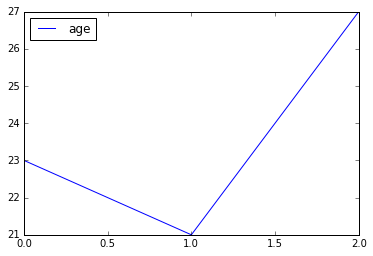

In [11]:
%matplotlib inline
pdf.plot()

# Selecting Columns

In [12]:
from pyspark.sql.functions import *

result = persons.select('name', col('age'))
result.toPandas()

,name,age
0,Alice,23
1,Bob,21
2,Charlie,27


In [14]:
result = persons.select(persons.name)
result.toPandas()

,name
0,Alice
1,Bob
2,Charlie


# Injecting Literal Values

In [16]:
result = persons.select(concat(lit('Name:'), persons.name, lit(' Age:'), persons.age).alias('text'))
result.toPandas()

,text
0,Name:Alice Age:23
1,Name:Bob Age:21
2,Name:Charlie Age:27


# Simple Transformations 

In [17]:
from pyspark.sql.functions import *

result = persons.select(persons.name, upper(persons.name).alias('upper_name'))
result.toPandas()

,name,upper_name
0,Alice,ALICE
1,Bob,BOB
2,Charlie,CHARLIE


In [18]:
from pyspark.sql.functions import *

result = persons.select(persons.name, (persons.age**2).alias('age_sqr'))
result.toPandas()

,name,age_sqr
0,Alice,529.0
1,Bob,441.0
2,Charlie,729.0


In [19]:
from pyspark.sql.functions import *

result = persons.select(
        concat(
            persons.name,
            lit('_'),
            persons.age.cast('string')
        ).alias('name_age')
    )
result.toPandas()

,name_age
0,Alice_23
1,Bob_21
2,Charlie_27


In [21]:
from pyspark.sql.functions import *

numbers = sqlContext.createDataFrame([(x,) for x in range(0,10)], ['number'])
result = numbers.select(
        numbers.number,
        when(numbers.number % 2 == 0, 'even').otherwise('odd').alias('text')
    )

result.toPandas()

,number,text
0,0,even
1,1,odd
2,2,even
3,3,odd
4,4,even
5,5,odd
6,6,even
7,7,odd
8,8,even
9,9,odd


# Adding Columns

In [22]:
from pyspark.sql.functions import *

result = numbers.withColumn("text", when(numbers.number % 2 == 0, 'even').otherwise('odd'))

result.toPandas()

,number,text
0,0,even
1,1,odd
2,2,even
3,3,odd
4,4,even
5,5,odd
6,6,even
7,7,odd
8,8,even
9,9,odd


# Dropping a Column

In [23]:
result2 = result.drop("number")

result2.toPandas()

,text
0,even
1,odd
2,even
3,odd
4,even
5,odd
6,even
7,odd
8,even
9,odd


# Filtering

In [25]:
result = persons.filter(persons.age > 22)
result.toPandas()

,age,name,sex
0,23,Alice,female
1,27,Charlie,male


In [27]:
result = persons.filter("age > 22")
result.toPandas()

,age,name,sex
0,23,Alice,female
1,27,Charlie,male


# Aggregations

In [29]:
from pyspark.sql.functions import *

df = sqlContext.createDataFrame([(x,) for x in range(0,100)], ['value'])
result = df.select(sum(df.value).alias('sum'), avg(df.value).alias('avg'), min(df.value).alias('min'), max(df.value).alias('max'), count(df.value).alias('count'))
result.toPandas()

,sum,avg,min,max,count
0,4950,49.5,0,99,100


# Making Data Distinct

In [30]:
from pyspark.sql.functions import *

df = sqlContext.createDataFrame([('Bob',),('Alice',),('Bob',)], ['name'])
result = df.distinct()
result.toPandas()

,name
0,Alice
1,Bob


# Grouping & Aggregating

In [35]:
result = persons.select(persons.sex,persons.age).groupBy(persons.sex).avg()
result.toPandas()

,sex,avg(age)
0,female,24.25
1,male,24.00


In [36]:
result = persons.groupBy(persons.sex).agg({'age':'max'}).withColumnRenamed('max(age)','max_age')
result.toPandas()

,sex,max_age
0,female,31
1,male,27


In [37]:
result = persons.groupBy(persons.sex).agg(
    avg(persons.age).alias('avg_age'),
    min(persons.height).alias('min_height'),
    max(persons.height).alias('max_height'))
result.toPandas()

,sex,avg_age,min_height,max_height
0,female,24.25,156,191
1,male,24.00,176,181


# Sorting Data

In [38]:
result = persons.orderBy(persons.height)
result.toPandas()

,age,height,name,sex
0,23,156,Alice,female
1,24,167,Eve,female
2,19,172,Frances,female
3,27,176,Charlie,male
4,21,181,Bob,male
5,31,191,George,female


In [40]:
result = persons.orderBy(persons.age.desc())
result.toPandas()

,age,height,name,sex
0,31,191,George,female
1,27,176,Charlie,male
2,24,167,Eve,female
3,23,156,Alice,female
4,21,181,Bob,male
5,19,172,Frances,female


# Joining Data

In [41]:
addresses = sqlContext.read.json("addresses.json")
result = persons.join(addresses,persons.name == addresses.name).select(persons.name,persons.age,addresses.city)
result.toPandas()

,name,age,city
0,Alice,23,Hamburg
1,Bob,21,Frankfurt


In [43]:
result = persons.join(addresses,persons.name == addresses.name, how="outer").select(persons.name,persons.age,addresses.city)
result.toPandas()

,name,age,city
0,Eve,24.0,None
1,Charlie,27.0,None
2,Alice,23.0,Hamburg
3,None,NaN,Berlin
4,Bob,21.0,Frankfurt
5,George,31.0,None
6,Frances,19.0,None


In [44]:
result = persons.join(addresses,persons.name == addresses.name, how="right").select(persons.name,persons.age,addresses.city)
result.toPandas()

,name,age,city
0,Alice,23.0,Hamburg
1,Bob,21.0,Frankfurt
2,None,NaN,Berlin


In [45]:
result = persons.join(addresses,persons.name == addresses.name, how="left").select(persons.name,persons.age,addresses.city)
result.toPandas()

,name,age,city
0,Alice,23,Hamburg
1,Bob,21,Frankfurt
2,Charlie,27,None
3,Eve,24,None
4,Frances,19,None
5,George,31,None


# User Defined Functions

In [46]:
import cgi
from pyspark.sql.functions import *
from pyspark.sql.types import *

html_encode = udf(lambda s: cgi.escape(s), StringType())

df = sqlContext.createDataFrame([('Alice & Bob',12),('Thelma & Louise',17)],['name','age'])
result = df.select(html_encode('name').alias('html_name'))

result.toPandas()

,html_name
0,Alice &amp; Bob
1,Thelma &amp; Louise


# Reading and Writing Data

In [48]:
df = sqlContext.read.text('/user/cloudera/alice-in-wonderland.txt')
df.toPandas()[0:10]

,value
0,Project Gutenberg's Alice's Adventures in Wond...
1,
2,This eBook is for the use of anyone anywhere a...
3,almost no restrictions whatsoever. You may co...
4,re-use it under the terms of the Project Guten...
5,with this eBook or online at www.gutenberg.org
6,
7,
8,Title: Alice's Adventures in Wonderland
9,


In [49]:
from pyspark.sql.functions import *

lines = persons.select(concat(persons.name, lit(','), persons.age).alias('value'))
lines.write.mode('overwrite').text('names_ages')

# WordCount Revisited

In [50]:
text = sqlContext.read.text('/user/cloudera/alice-in-wonderland.txt')
words = text.select(explode(split(text.value,' ')).alias('word')).filter(col('word') != '')
counts = words.groupBy(words.word).count().orderBy('count',ascending=False)

counts.toPandas()

,word,count
0,the,1664
1,and,780
2,to,773
3,a,662
4,of,596
5,she,484
6,said,416
7,in,401
8,it,356
9,was,329


# Accessing Hive Tables

In [35]:
tables = sqlContext.tables(dbName='training')
tables.toPandas()

,tableName,isTemporary
0,bike_sharing,False
1,stations,False
2,weather,False
3,weather_raw,False


In [36]:
sqlContext.tableNames(dbName='training')

[u'bike_sharing', u'stations', u'weather', u'weather_raw']

In [37]:
df = sqlContext.table('training.stations')
df.toPandas()[0:10]

,usaf,wban,name,country,state,icao,latitude,longitude,elevation,date_begin,date_end
0,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
1,007005,99999,CWOS 07005,,,,,,,20120127,20120127
2,007011,99999,CWOS 07011,,,,,,,20111025,20121129
3,007018,99999,WXPOD 7018,,,,+00.000,+000.000,+7018.0,20110309,20130730
4,007025,99999,CWOS 07025,,,,,,,20120127,20120127
5,007026,99999,WXPOD 7026,AF,,,+00.000,+000.000,+7026.0,20120713,20141120
6,007034,99999,CWOS 07034,,,,,,,20121024,20121106
7,007037,99999,CWOS 07037,,,,,,,20111202,20121125
8,007044,99999,CWOS 07044,,,,,,,20120127,20120127
9,007047,99999,CWOS 07047,,,,,,,20120613,20120717


# Statistics

In [38]:
df = sqlContext.table('training.stations').limit(20)
df.toPandas()

,usaf,wban,name,country,state,icao,latitude,longitude,elevation,date_begin,date_end
0,703950,25325,KETCHIKAN INTL AIRPORT,US,AK,PAKT,+55.357,-131.712,+0023.2,19730101,20151122
1,703980,25308,ANNETTE ISLAND AIRPORT,US,AK,PANT,+55.039,-131.579,+0033.2,19410714,20151122
2,703985,25377,METLAKATLA SEAPLANE BASE,US,AK,PAMM,+55.131,-131.578,+0000.0,20060101,20151122
3,703985,99999,METLAKATLA SEAPLANE,US,AK,PAMM,+55.133,-131.583,+0000.0,19980226,20051231
4,704090,45709,ATTU,US,AK,,+52.833,+173.183,+0021.0,19430607,19871020
5,704140,45715,EARECKSON AIR STATION AIRPORT,US,AK,PASY,+52.717,+174.100,+0037.2,20050101,20151122
6,704140,99999,EARECKSON AS,US,AK,PASY,+52.717,+174.100,+0031.0,19430621,20041231
7,704540,25704,ADAK NAS,US,AK,PADK,+51.883,-176.650,+0005.2,19421030,20151122
8,704540,99999,ADAK (NAS),US,AK,PADK,+51.883,-176.650,+0005.0,20000101,20031231
9,704545,99999,AMCHITKA ISLAND,US,AK,,+51.383,+179.267,+0069.0,19430131,19931001


In [39]:
weather = sqlContext.table('training.weather')
weather.stat.corr('wind_speed', 'air_temperature')

0.09466656877857038